# Final Analysis of  VLMs for Creativity Level based on Paradelia Symptoms  

### Data loading

#### Setup & Paths

In [23]:
# FacesInThings — Multi-Model Comparison (Unified Pipeline)

from pathlib import Path
import json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (8, 5)})

# ====== CONFIG: change BASE_DIR if needed ======
BASE_DIR = Path.home() / "Desktop" / "creativity"

GT_CSV = (BASE_DIR / "FacesinThings" / "metadata.csv")  # ground truth

# Candidate model outputs
FILES = {
    "gemini": BASE_DIR / "Code" / "gemini" / "out" / "gemini_all.jsonl",
    "qwen":   BASE_DIR / "Code" / "qwen"   / "out" / "qwen_all.jsonl",
    "gemma":  BASE_DIR / "Code" / "gemma"  / "out" / "gemma_all.jsonl",
    # "gpt4o":  BASE_DIR / "Code" / "gpt4o"  / "out" / "gpt4o_all.jsonl",  # optional
}

OUT_DIR   = BASE_DIR / "Code" / "compare_out"
PLOTS_DIR = OUT_DIR / "plots"
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

available = {m:p for m,p in FILES.items() if p.exists()}
print("GT exists:", GT_CSV.exists())
print("Found model files:", {k: str(v) for k,v in available.items()})


GT exists: True
Found model files: {'gemini': '/Users/precioux/Desktop/creativity/Code/gemini/out/gemini_all.jsonl', 'qwen': '/Users/precioux/Desktop/creativity/Code/qwen/out/qwen_all.jsonl', 'gemma': '/Users/precioux/Desktop/creativity/Code/gemma/out/gemma_all.jsonl'}


#### Attributes & Canonical Classes

In [24]:
ATTRS = [
    "Hard to spot?",
    "Accident or design?",
    "Emotion?",
    "Person or creature?",
    "Gender?",
    "Amusing?",
]

CANON = {
    "Hard to spot?":        ["Easy", "Medium", "Hard"],
    "Accident or design?":  ["Accident", "Design"],
    "Emotion?":             ["Happy","Neutral","Disgusted","Angry","Surprised","Scared","Sad","Other"],
    "Person or creature?":  ["Human-Adult","Human-Old","Human-Young","Cartoon","Animal","Robot","Alien","Other"],
    "Gender?":              ["Male","Female","Neutral"],
    "Amusing?":             ["Yes","Somewhat","No"],
}


#### Normalization Helpers

In [25]:
NORM = {
    "Hard to spot?": {
        "easy":"Easy","e":"Easy","medium":"Medium","med":"Medium",
        "hard":"Hard","difficult":"Hard"
    },
    "Accident or design?": {
        "accident":"Accident","accidental":"Accident",
        "design":"Design","designed":"Design","intentional":"Design"
    },
    "Emotion?": {
        "happy":"Happy","smile":"Happy","smiling":"Happy","joy":"Happy",
        "neutral":"Neutral","none":"Neutral","no emotion":"Neutral",
        "disgust":"Disgusted","disgusted":"Disgusted",
        "angry":"Angry","mad":"Angry",
        "surprised":"Surprised","astonished":"Surprised",
        "scared":"Scared","afraid":"Scared",
        "sad":"Sad","unhappy":"Sad",
        "other":"Other","unknown":"Other","unsure":"Other"
    },
    "Person or creature?": {
        "human":"Human-Adult","adult":"Human-Adult","person":"Human-Adult",
        "old":"Human-Old","elderly":"Human-Old","senior":"Human-Old",
        "young":"Human-Young","child":"Human-Young","kid":"Human-Young",
        "cartoon":"Cartoon","drawing":"Cartoon","illustration":"Cartoon",
        "animal":"Animal","dog":"Animal","cat":"Animal","creature":"Animal",
        "robot":"Robot","android":"Robot",
        "alien":"Alien",
        "other":"Other","unknown":"Other","unsure":"Other"
    },
    "Gender?": {
        "male":"Male","man":"Male","boy":"Male",
        "female":"Female","woman":"Female","girl":"Female",
        "neutral":"Neutral","unknown":"Neutral","unsure":"Neutral","other":"Neutral"
    },
    "Amusing?": {
        "yes":"Yes","true":"Yes","y":"Yes",
        "somewhat":"Somewhat","maybe":"Somewhat","kinda":"Somewhat","kind of":"Somewhat",
        "no":"No","false":"No","n":"No"
    },
}

def normalize_attr_value(attr, val):
    if pd.isna(val): return None
    s = str(val).strip()
    if not s: return None
    if s in CANON[attr]:
        return s
    key = s.lower()
    if key in NORM.get(attr, {}):
        return NORM[attr][key]
    t = key.title()
    if t in CANON[attr]:
        return t
    return None


#### JSONL Loader

In [26]:
def load_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line=line.strip()
            if not line: 
                continue
            try:
                obj = json.loads(line)
            except Exception as e:
                rows.append({"_raw": line, "parse_error": str(e)})
                continue
            rows.append(obj)
    df = pd.DataFrame(rows)
    for col in ["image_path","model","error","latency_ms"] + ATTRS:
        if col not in df.columns:
            df[col] = None
    if "image_path" in df.columns:
        df["image_path"] = df["image_path"].astype(str)
    return df


#### Metric Utilities

In [27]:
def confusion_from_series(gt, pred, labels):
    idx = {lab:i for i,lab in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    for g,p in zip(gt,pred):
        if g in idx and p in idx:
            cm[idx[g], idx[p]] += 1
    return cm

def metrics_from_confusion(cm):
    K = cm.shape[0]
    support = cm.sum(axis=1)
    pred_tot = cm.sum(axis=0)
    total = cm.sum()
    TP = np.diag(cm)
    FP = pred_tot - TP
    FN = support - TP

    prec, rec, f1 = np.zeros(K), np.zeros(K), np.zeros(K)
    for i in range(K):
        pden, rden = TP[i]+FP[i], TP[i]+FN[i]
        prec[i] = TP[i]/pden if pden>0 else np.nan
        rec[i]  = TP[i]/rden if rden>0 else np.nan
        if prec[i]+rec[i]>0 and not np.isnan(prec[i]) and not np.isnan(rec[i]):
            f1[i]=2*prec[i]*rec[i]/(prec[i]+rec[i])
        else:
            f1[i]=np.nan

    acc = TP.sum()/total if total>0 else np.nan  # micro-F1 == accuracy in single-label
    micro_f1 = acc
    macro_f1 = np.nanmean(f1[~np.isnan(f1)]) if (~np.isnan(f1)).any() else np.nan
    weighted_f1 = np.nansum(f1*support/support.sum()) if support.sum()>0 else np.nan

    return {
        "accuracy":acc, "micro_f1":micro_f1,
        "macro_f1":macro_f1, "weighted_f1":weighted_f1,
        "per_class_precision":prec,"per_class_recall":rec,"per_class_f1":f1,
        "support":support,"total":total
    }


#### Load Ground Truth

In [30]:
# --- Load Ground Truth (metadata.csv) ---
import pandas as pd

assert GT_CSV.exists(), f"Missing ground truth CSV: {GT_CSV}"
gt = pd.read_csv(GT_CSV)

# Use 'file' column as the image identifier
gt["image_path"] = gt["file"].astype(str)

# Also add a "key" column = basename only (for safe merging)
gt["key"] = gt["image_path"].apply(lambda x: x.split("/")[-1].lower())

print("GT rows:", len(gt))
print("GT columns:", gt.columns.tolist())
gt.head(3)


GT rows: 4537
GT columns: ['file', 'url', 'boxes', 'is_primary', 'Is there a face?', 'Hard to spot?', 'Accident or design?', 'Emotion?', 'Person or creature?', 'Gender?', 'Amusing?', 'Common?', 'Flags', 'num_boxes', 'train', 'split', 'image_path', 'key']


,file,url,boxes,is_primary,Is there a face?,Hard to spot?,Accident or design?,Emotion?,Person or creature?,Gender?,Amusing?,Common?,Flags,num_boxes,train,split,image_path,key
0,000007038.jpg,https://raw.githubusercontent.com/3lbom/pareidolia/main/data/00000/000007038.jpg,"[[202.105, 160.975, 233.308, 190.05]]",[True],Yes,Hard,Accident,Neutral,Animal,Neutral,Somewhat,Uncommon,['Interesting'],1,False,3,000007038.jpg,000007038.jpg
1,000018844.jpg,https://raw.githubusercontent.com/3lbom/pareidolia/main/data/00001/000018844.jpg,"[[138, 288, 83, 71]]",[True],Yes,Hard,Accident,Neutral,Human-Old,Male,No,Uncommon,NaN,1,True,0,000018844.jpg,000018844.jpg
2,000026283.jpg,https://raw.githubusercontent.com/3lbom/pareidolia/main/data/00002/000026283.jpg,"[[268, 315, 16, 26], [316, 266, 21, 17]]","[False, True]",Several,Easy,Design,Neutral,Cartoon,Neutral,No,Uncommon,['Interesting'],2,False,1,000026283.jpg,000026283.jpg


#### Load Predictions

In [31]:
models = {}
for name, path in available.items():
    df = load_jsonl(path)
    if "model" in df.columns and df["model"].notna().any():
        model_name = str(df["model"].dropna().iloc[0])
    else:
        model_name = name
        df["model"] = model_name
    models[model_name] = df
print({k: len(v) for k,v in models.items()})


{'gemini-2.5-flash-lite': 4827, 'qwen2.5vl': 134, 'gemma3': 4827}


#### Merge + Normalize

In [32]:
# --- Add a 'key' column to each model DF for merging ---
for name, df in models.items():
    if "image_path" not in df.columns:
        # sometimes models might log 'file' instead
        df["image_path"] = df["file"] if "file" in df.columns else None
    df["image_path"] = df["image_path"].astype(str)

    # Use only the basename (case-insensitive)
    df["key"] = df["image_path"].apply(lambda x: x.split("/")[-1].lower())


In [34]:
# --- Merge + Normalize on 'key' (basename), suffix-aware ---
def prepare_merged(df_pred: pd.DataFrame, df_gt: pd.DataFrame) -> pd.DataFrame:
    # Merge by basename key; overlapping columns get _gt and _predfile
    merged = df_gt.merge(df_pred, on="key", how="left", suffixes=("_gt", "_predfile"))

    # Pick a unified image_path column
    merged["image_path"] = np.where(
        merged.get("image_path_predfile").notna() if "image_path_predfile" in merged.columns else False,
        merged.get("image_path_predfile"),
        merged.get("image_path_gt")
    )

    # If latency exists on pred side, keep it; else fill with NaN
    if "latency_ms_predfile" in merged.columns:
        merged["latency_ms"] = pd.to_numeric(merged["latency_ms_predfile"], errors="coerce")
    elif "latency_ms" in merged.columns:
        # (in case there was no overlap / no suffix)
        merged["latency_ms"] = pd.to_numeric(merged["latency_ms"], errors="coerce")
    else:
        merged["latency_ms"] = np.nan

    # Build aligned *_gt and *_pred columns, then normalize
    for attr in ATTRS:
        gt_col   = f"{attr}_gt"        if f"{attr}_gt"        in merged.columns else (attr if attr in merged.columns else None)
        pred_col = f"{attr}_predfile"  if f"{attr}_predfile"  in merged.columns else (attr if attr in merged.columns else None)

        # Raw aligned columns (may be None if missing from either side)
        merged[f"{attr}_gt_raw"]   = merged[gt_col]   if gt_col   is not None else np.nan
        merged[f"{attr}_pred_raw"] = merged[pred_col] if pred_col is not None else np.nan

        # Normalized
        merged[f"{attr}_gt_norm"]   = merged[f"{attr}_gt_raw"].apply(lambda x: normalize_attr_value(attr, x))
        merged[f"{attr}_pred_norm"] = merged[f"{attr}_pred_raw"].apply(lambda x: normalize_attr_value(attr, x))

        # Valid row = both sides mapped to known canonical classes
        merged[f"{attr}_is_valid"] = (
            merged[f"{attr}_gt_norm"].isin(CANON[attr]) &
            merged[f"{attr}_pred_norm"].isin(CANON[attr])
        )

        # (Optional) a concise predicted column if you want it later
        merged[f"{attr}_pred"] = merged[f"{attr}_pred_raw"]

    return merged

# Rebuild merged_by_model with the fixed function
merged_by_model = {name: prepare_merged(df, gt) for name, df in models.items()}
{k: v.shape for k, v in merged_by_model.items()}


{'gemini-2.5-flash-lite': (4537, 66),
 'qwen2.5vl': (4537, 66),
 'gemma3': (4537, 66)}

## Evaluation (Baseline Metrics)

In [35]:
import math

summary_rows, perclass_rows = [], []

for model_name, merged in merged_by_model.items():
    total_rows = len(merged)
    for attr in ATTRS:
        sub = merged.loc[ merged[f"{attr}_is_valid"] ].copy()
        labels = CANON[attr]

        gt = sub[f"{attr}_gt_norm"].tolist()
        pr = sub[f"{attr}_pred_norm"].tolist()

        cm = confusion_from_series(gt, pr, labels)
        m  = metrics_from_confusion(cm)

        coverage = len(sub) / total_rows if total_rows > 0 else float("nan")

        summary_rows.append({
            "model": model_name,
            "attribute": attr,
            "support": int(m["total"]),
            "coverage": coverage,
            "accuracy": m["accuracy"],
            "micro_f1": m["micro_f1"],
            "macro_f1": m["macro_f1"],
            "weighted_f1": m["weighted_f1"],
        })

        for i, lab in enumerate(labels):
            perclass_rows.append({
                "model": model_name,
                "attribute": attr,
                "class": lab,
                "support": int(m["support"][i]),
                "precision": (None if math.isnan(m["per_class_precision"][i]) else float(m["per_class_precision"][i])),
                "recall":    (None if math.isnan(m["per_class_recall"][i])    else float(m["per_class_recall"][i])),
                "f1":        (None if math.isnan(m["per_class_f1"][i])        else float(m["per_class_f1"][i])),
            })

summary  = pd.DataFrame(summary_rows)
perclass = pd.DataFrame(perclass_rows)

summary_path  = OUT_DIR / "comparison_summary.csv"
perclass_path = OUT_DIR / "comparison_perclass.csv"
summary.to_csv(summary_path, index=False)
perclass.to_csv(perclass_path, index=False)

print("Saved:", summary_path)
print("Saved:", perclass_path)
summary.head(12)


Saved: /Users/precioux/Desktop/creativity/Code/compare_out/comparison_summary.csv
Saved: /Users/precioux/Desktop/creativity/Code/compare_out/comparison_perclass.csv


,model,attribute,support,coverage,accuracy,micro_f1,macro_f1,weighted_f1
0,gemini-2.5-flash-lite,Hard to spot?,3834,0.845052,0.636672,0.636672,0.403235,0.612645
1,gemini-2.5-flash-lite,Accident or design?,3854,0.849460,0.825376,0.825376,0.824094,0.823713
2,gemini-2.5-flash-lite,Emotion?,3867,0.852325,0.607706,0.607706,0.287622,0.591019
3,gemini-2.5-flash-lite,Person or creature?,3862,0.851223,0.289746,0.289746,0.197086,0.264314
4,gemini-2.5-flash-lite,Gender?,3860,0.850782,0.817358,0.817358,0.440778,0.761155
5,gemini-2.5-flash-lite,Amusing?,3866,0.852105,0.198655,0.198655,0.200594,0.222688
6,qwen2.5vl,Hard to spot?,19,0.004188,0.157895,0.157895,0.315789,0.049861
7,qwen2.5vl,Accident or design?,19,0.004188,0.894737,0.894737,0.944444,0.845029
8,qwen2.5vl,Emotion?,19,0.004188,0.736842,0.736842,0.816425,0.704043
9,qwen2.5vl,Person or creature?,19,0.004188,0.368421,0.368421,0.462302,0.415622


## Fairness Metrics

In [45]:
# --- Strict metrics: abstentions counted as wrong ---
strict_rows = []

for model_name, merged in merged_by_model.items():
    total_rows = len(merged)
    for attr in ATTRS:
        # valid preds for this attr
        valid = merged[merged[f"{attr}_is_valid"]]
        # accuracy on valid subset
        acc_valid = np.nan
        if len(valid) > 0:
            acc_valid = (valid[f"{attr}_gt_norm"].values == valid[f"{attr}_pred_norm"].values).mean()

        # strict accuracy: scale by coverage (abstain = wrong)
        coverage = len(valid) / total_rows if total_rows > 0 else np.nan
        acc_strict = acc_valid * coverage if not (pd.isna(acc_valid) or pd.isna(coverage)) else np.nan

        strict_rows.append({
            "model": model_name,
            "attribute": attr,
            "total_rows": total_rows,
            "valid_rows": len(valid),
            "coverage": coverage,
            "accuracy_valid_only": acc_valid,
            "accuracy_strict": acc_strict,  # key metric: abstain counted wrong
            "abstain_rate": (1 - coverage) if not pd.isna(coverage) else np.nan,
        })

strict = pd.DataFrame(strict_rows)
strict_path = OUT_DIR / "comparison_strict.csv"
strict.to_csv(strict_path, index=False)
print("Saved:", strict_path)

# Quick view
strict.sort_values(["attribute","accuracy_strict"], ascending=[True, False]).head(24)


Saved: /Users/precioux/Desktop/creativity/Code/compare_out/comparison_strict.csv


,model,attribute,total_rows,valid_rows,coverage,accuracy_valid_only,accuracy_strict,abstain_rate
1,gemini-2.5-flash-lite,Accident or design?,4537,3854,0.849460,0.825376,0.701124,0.150540
13,gemma3,Accident or design?,4537,3785,0.834252,0.486129,0.405554,0.165748
7,qwen2.5vl,Accident or design?,4537,19,0.004188,0.894737,0.003747,0.995812
17,gemma3,Amusing?,4537,3797,0.836897,0.316829,0.265153,0.163103
5,gemini-2.5-flash-lite,Amusing?,4537,3866,0.852105,0.198655,0.169275,0.147895
11,qwen2.5vl,Amusing?,4537,19,0.004188,0.210526,0.000882,0.995812
2,gemini-2.5-flash-lite,Emotion?,4537,3867,0.852325,0.607706,0.517963,0.147675
14,gemma3,Emotion?,4537,3798,0.837117,0.543971,0.455367,0.162883
8,qwen2.5vl,Emotion?,4537,19,0.004188,0.736842,0.003086,0.995812
4,gemini-2.5-flash-lite,Gender?,4537,3860,0.850782,0.817358,0.695393,0.149218


#### Coverage-weighted leaderboard

In [46]:
# --- Coverage-weighted leaderboard (per attribute and overall) ---
cw_attr = (
    strict.groupby(["attribute","model"], as_index=False)["accuracy_strict"]
          .mean()
          .sort_values(["attribute","accuracy_strict"], ascending=[True, False])
)

cw_overall = (
    strict.groupby("model", as_index=False)["accuracy_strict"]
          .mean()
          .sort_values("accuracy_strict", ascending=False)
)

cw_attr_path = OUT_DIR / "coverage_weighted_by_attribute.csv"
cw_overall_path = OUT_DIR / "coverage_weighted_overall.csv"
cw_attr.to_csv(cw_attr_path, index=False)
cw_overall.to_csv(cw_overall_path, index=False)
print("Saved:", cw_attr_path)
print("Saved:", cw_overall_path)

cw_overall


Saved: /Users/precioux/Desktop/creativity/Code/compare_out/coverage_weighted_by_attribute.csv
Saved: /Users/precioux/Desktop/creativity/Code/compare_out/coverage_weighted_overall.csv


,model,accuracy_strict
0,gemini-2.5-flash-lite,0.478069
1,gemma3,0.356293
2,qwen2.5vl,0.002131


#### Common-set comparison (head-to-head on the exact same images)

In [47]:
# --- Common-set accuracy (all models valid on the same rows) ---
common_rows = []

# Build per-model valid keys per attribute
valid_keys = {
    model_name: {
        attr: set(df.loc[df[f"{attr}_is_valid"], "key"].astype(str))
        for attr in ATTRS
    }
    for model_name, df in merged_by_model.items()
}

all_models = list(merged_by_model.keys())

for attr in ATTRS:
    # intersection of valid keys over all models for this attr
    common = None
    for m in all_models:
        ks = valid_keys[m][attr]
        common = ks if common is None else (common & ks)

    common = set() if common is None else common

    if len(common) == 0:
        # no common rows available for all models on this attr
        for m in all_models:
            common_rows.append({
                "attribute": attr,
                "model": m,
                "common_support": 0,
                "common_accuracy": np.nan,
            })
        continue

    # compute accuracy per model on the common subset
    for m in all_models:
        merged = merged_by_model[m]
        sub = merged[merged["key"].isin(common)].copy()
        ok = sub[f"{attr}_is_valid"]
        sub = sub[ok]

        acc = (sub[f"{attr}_gt_norm"].values == sub[f"{attr}_pred_norm"].values).mean() if len(sub) > 0 else np.nan
        common_rows.append({
            "attribute": attr,
            "model": m,
            "common_support": len(sub),
            "common_accuracy": acc,
        })

common_df = pd.DataFrame(common_rows)
common_path = OUT_DIR / "common_set_accuracy.csv"
common_df.to_csv(common_path, index=False)
print("Saved:", common_path)

# Quick view
common_df.sort_values(["attribute","common_accuracy"], ascending=[True, False]).head(24)


Saved: /Users/precioux/Desktop/creativity/Code/compare_out/common_set_accuracy.csv


,attribute,model,common_support,common_accuracy
3,Accident or design?,gemini-2.5-flash-lite,14,1.000000
4,Accident or design?,qwen2.5vl,14,0.928571
5,Accident or design?,gemma3,14,0.928571
15,Amusing?,gemini-2.5-flash-lite,14,0.285714
16,Amusing?,qwen2.5vl,14,0.285714
17,Amusing?,gemma3,14,0.285714
6,Emotion?,gemini-2.5-flash-lite,14,0.785714
7,Emotion?,qwen2.5vl,14,0.714286
8,Emotion?,gemma3,14,0.500000
12,Gender?,gemini-2.5-flash-lite,14,0.642857


#### Add binomial 95% CIs (so tiny sample sizes don’t look over-confident)

In [48]:
# --- Wilson 95% confidence interval for accuracy ---
from math import sqrt

def wilson_ci(k, n, z=1.96):
    if n == 0: 
        return (np.nan, np.nan)
    p = k/n
    denom = 1 + z**2/n
    center = p + z*z/(2*n)
    margin = z * sqrt((p*(1-p) + z*z/(4*n)) / n)
    lo = (center - margin)/denom
    hi = (center + margin)/denom
    return (max(0.0, lo), min(1.0, hi))

# Add CI to valid-only and common-set accuracies
def add_ci(df, acc_col, support_col, out_prefix):
    rows = []
    for _, r in df.iterrows():
        acc = r[acc_col]
        n = int(r[support_col])
        if pd.isna(acc) or n == 0:
            lo, hi = np.nan, np.nan
        else:
            k = int(round(acc * n))
            lo, hi = wilson_ci(k, n)
        new = dict(r)
        new[f"{out_prefix}_lo"] = lo
        new[f"{out_prefix}_hi"] = hi
        rows.append(new)
    return pd.DataFrame(rows)

# valid-only CI (from `summary`: support is m["total"])
summary_ci = add_ci(
    summary.rename(columns={"support":"n_valid", "accuracy":"acc_valid"}),
    acc_col="acc_valid", support_col="n_valid", out_prefix="acc_valid_ci"
)
summary_ci_path = OUT_DIR / "summary_with_ci.csv"
summary_ci.to_csv(summary_ci_path, index=False)
print("Saved:", summary_ci_path)

# common-set CI
common_ci = add_ci(
    common_df.rename(columns={"common_support":"n_common", "common_accuracy":"acc_common"}),
    acc_col="acc_common", support_col="n_common", out_prefix="acc_common_ci"
)
common_ci_path = OUT_DIR / "common_set_with_ci.csv"
common_ci.to_csv(common_ci_path, index=False)
print("Saved:", common_ci_path)

common_ci.sort_values(["attribute","acc_common"], ascending=[True, False]).head(24)


Saved: /Users/precioux/Desktop/creativity/Code/compare_out/summary_with_ci.csv
Saved: /Users/precioux/Desktop/creativity/Code/compare_out/common_set_with_ci.csv


,attribute,model,n_common,acc_common,acc_common_ci_lo,acc_common_ci_hi
3,Accident or design?,gemini-2.5-flash-lite,14,1.000000,0.784683,1.000000
4,Accident or design?,qwen2.5vl,14,0.928571,0.685307,0.987278
5,Accident or design?,gemma3,14,0.928571,0.685307,0.987278
15,Amusing?,gemini-2.5-flash-lite,14,0.285714,0.117212,0.546495
16,Amusing?,qwen2.5vl,14,0.285714,0.117212,0.546495
17,Amusing?,gemma3,14,0.285714,0.117212,0.546495
6,Emotion?,gemini-2.5-flash-lite,14,0.785714,0.524103,0.924288
7,Emotion?,qwen2.5vl,14,0.714286,0.453505,0.882788
8,Emotion?,gemma3,14,0.500000,0.267989,0.732011
12,Gender?,gemini-2.5-flash-lite,14,0.642857,0.387640,0.836555


#### Small plot: strict accuracy vs. coverage (Pareto view)

Saved plot: /Users/precioux/Desktop/creativity/Code/compare_out/plots/strict_accuracy_vs_coverage.png


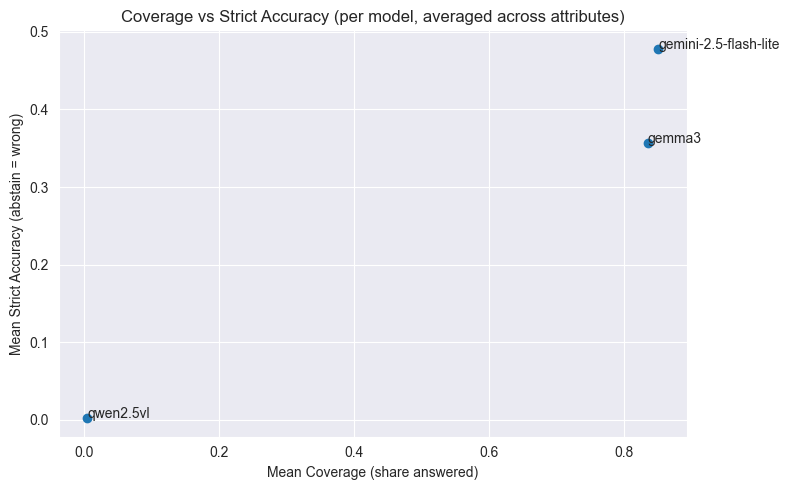

,model,mean_coverage,mean_accuracy_valid,mean_accuracy_strict,mean_abstain
0,gemini-2.5-flash-lite,0.850158,0.562586,0.478069,0.149842
1,gemma3,0.834913,0.426588,0.356293,0.165087
2,qwen2.5vl,0.004188,0.508772,0.002131,0.995812


In [49]:
# --- Strict accuracy vs coverage scatter (averaged across attrs) ---
agg_strict = strict.groupby("model", as_index=False).agg(
    mean_coverage=("coverage","mean"),
    mean_accuracy_valid=("accuracy_valid_only","mean"),
    mean_accuracy_strict=("accuracy_strict","mean"),
    mean_abstain=("abstain_rate","mean"),
)

fig, ax = plt.subplots()
ax.scatter(agg_strict["mean_coverage"], agg_strict["mean_accuracy_strict"])
for _, r in agg_strict.iterrows():
    ax.annotate(r["model"], (r["mean_coverage"], r["mean_accuracy_strict"]))
ax.set_xlabel("Mean Coverage (share answered)")
ax.set_ylabel("Mean Strict Accuracy (abstain = wrong)")
ax.set_title("Coverage vs Strict Accuracy (per model, averaged across attributes)")
fig.tight_layout()
fig_path = PLOTS_DIR / "strict_accuracy_vs_coverage.png"
fig.savefig(fig_path, dpi=150)
print("Saved plot:", fig_path)
plt.show()

agg_strict.sort_values("mean_accuracy_strict", ascending=False)


## Winners by Attribute

In [50]:
winners = []
for attr in ATTRS:
    sub = summary[summary["attribute"] == attr]
    if len(sub) == 0:
        continue
    best = sub["macro_f1"].max()
    win_models = sub.loc[sub["macro_f1"] == best, "model"].tolist()
    winners.append({"attribute": attr, "best_macro_f1": best, "winners": ", ".join(sorted(win_models))})

winners_df = pd.DataFrame(winners)
winners_path = OUT_DIR / "winners_by_attribute.csv"
winners_df.to_csv(winners_path, index=False)
print("Saved:", winners_path)
winners_df


Saved: /Users/precioux/Desktop/creativity/Code/compare_out/winners_by_attribute.csv


,attribute,best_macro_f1,winners
0,Hard to spot?,0.403235,gemini-2.5-flash-lite
1,Accident or design?,0.944444,qwen2.5vl
2,Emotion?,0.816425,qwen2.5vl
3,Person or creature?,0.462302,qwen2.5vl
4,Gender?,0.642857,qwen2.5vl
5,Amusing?,0.363636,qwen2.5vl


## Plots — Accuracy

Saved plot: /Users/precioux/Desktop/creativity/Code/compare_out/plots/accuracy_by_attribute.png


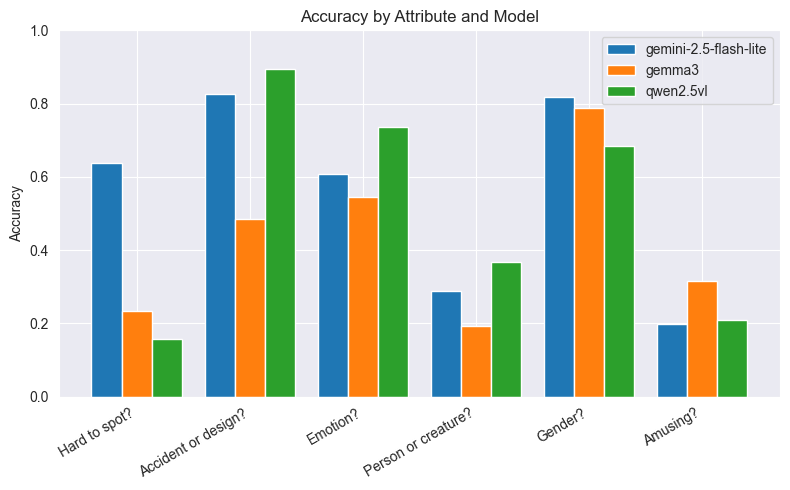

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_bars(summary: pd.DataFrame):
    if len(summary) == 0:
        print("No data to plot."); return
    attrs = ATTRS
    models_sorted = sorted(summary["model"].unique())
    x = np.arange(len(attrs))
    width = 0.8 / max(1, len(models_sorted))

    fig, ax = plt.subplots()
    for i, m in enumerate(models_sorted):
        sub = summary[summary["model"] == m].set_index("attribute").reindex(attrs)
        y = sub["accuracy"].values
        ax.bar(x + i*width, y, width, label=m)
    ax.set_xticks(x + (len(models_sorted)-1)*width/2)
    ax.set_xticklabels(attrs, rotation=30, ha="right")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy by Attribute and Model")
    ax.legend()
    fig.tight_layout()
    fig_path = PLOTS_DIR / "accuracy_by_attribute.png"
    fig.savefig(fig_path, dpi=150)
    print("Saved plot:", fig_path)
    plt.show()

plot_accuracy_bars(summary)


## Plots — Macro-F1

Saved plot: /Users/precioux/Desktop/creativity/Code/compare_out/plots/macro_f1_by_attribute.png


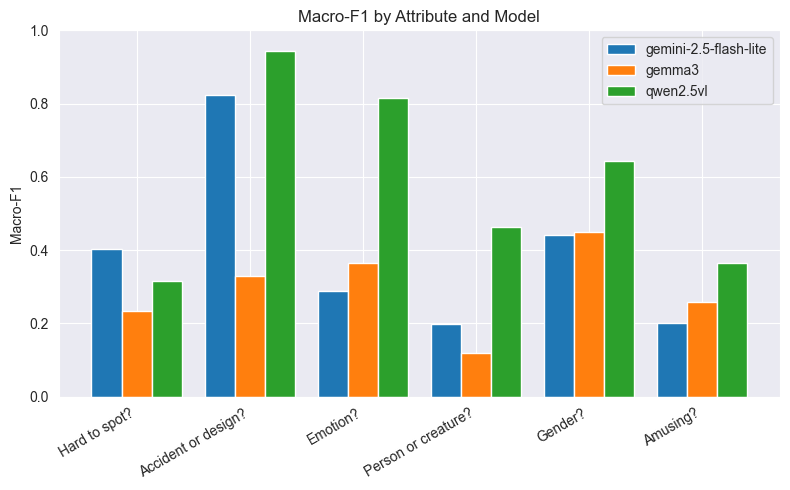

In [38]:
def plot_macro_f1_bars(summary: pd.DataFrame):
    if len(summary) == 0:
        print("No data to plot."); return
    attrs = ATTRS
    models_sorted = sorted(summary["model"].unique())
    x = np.arange(len(attrs))
    width = 0.8 / max(1, len(models_sorted))

    fig, ax = plt.subplots()
    for i, m in enumerate(models_sorted):
        sub = summary[summary["model"] == m].set_index("attribute").reindex(attrs)
        y = sub["macro_f1"].values
        ax.bar(x + i*width, y, width, label=m)
    ax.set_xticks(x + (len(models_sorted)-1)*width/2)
    ax.set_xticklabels(attrs, rotation=30, ha="right")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Macro-F1")
    ax.set_title("Macro-F1 by Attribute and Model")
    ax.legend()
    fig.tight_layout()
    fig_path = PLOTS_DIR / "macro_f1_by_attribute.png"
    fig.savefig(fig_path, dpi=150)
    print("Saved plot:", fig_path)
    plt.show()

plot_macro_f1_bars(summary)


## Confusion Matrices

In [55]:
# === Plot & show every confusion matrix inline + save to disk ===
def plot_confusion(cm, labels, title, fname=None, annotate=True):
    total = int(cm.sum()) if cm.size else 0
    if total == 0:
        print(f"[skip] {title}: no valid rows (cm sum = 0).")
        return

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Ground Truth")
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if annotate:
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax.text(j, i, str(int(cm[i, j])),
                        ha="center", va="center", color="black")

    fig.tight_layout()
    if fname:
        fig.savefig(fname, dpi=150)
        print("Saved:", fname)
    plt.show()   # <- always show inline (don’t close)


Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemini-2.5-flash-lite__Hard_to_spot.png


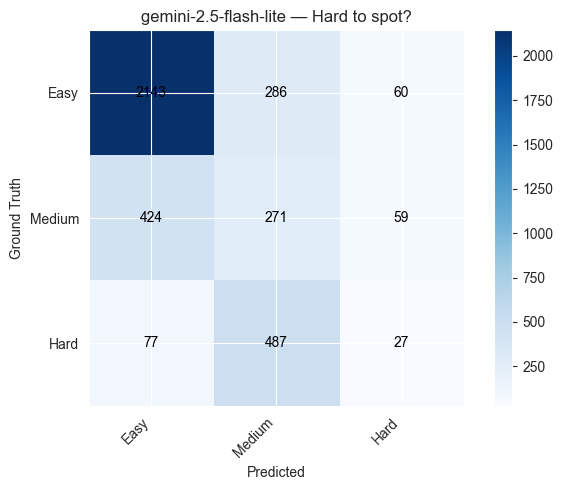

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemini-2.5-flash-lite__Accident_or_design.png


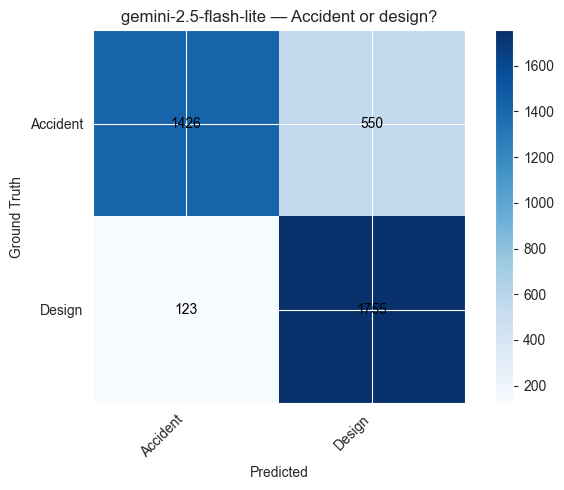

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemini-2.5-flash-lite__Emotion.png


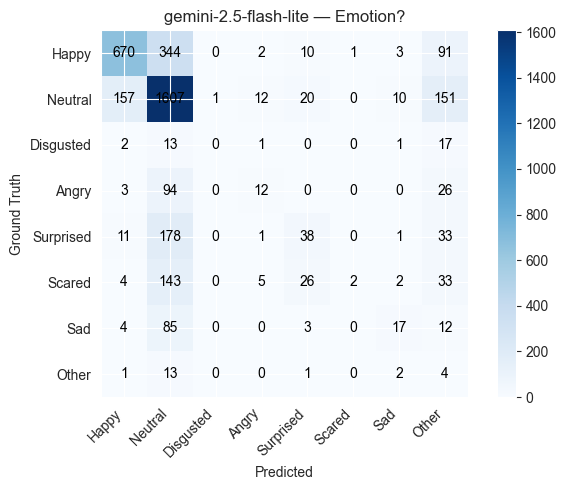

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemini-2.5-flash-lite__Person_or_creature.png


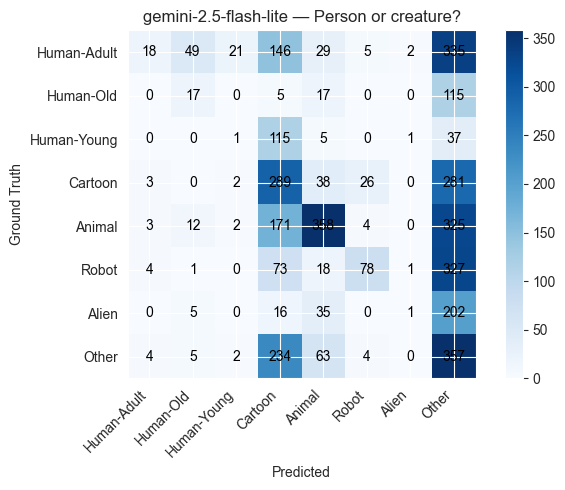

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemini-2.5-flash-lite__Gender.png


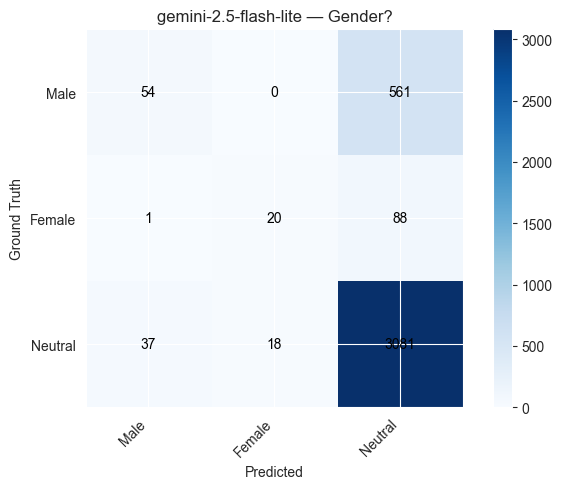

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemini-2.5-flash-lite__Amusing.png


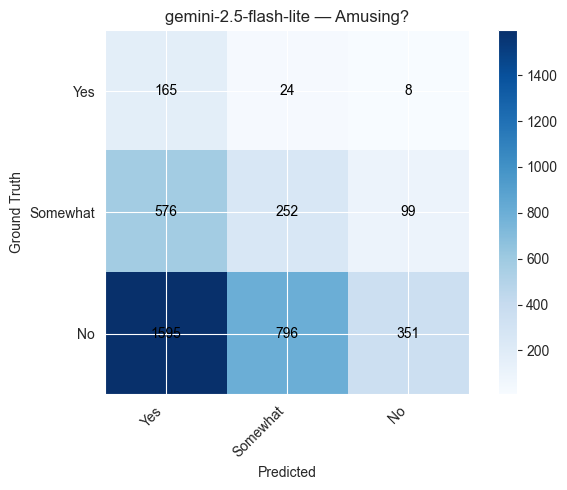

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__qwen2.5vl__Hard_to_spot.png


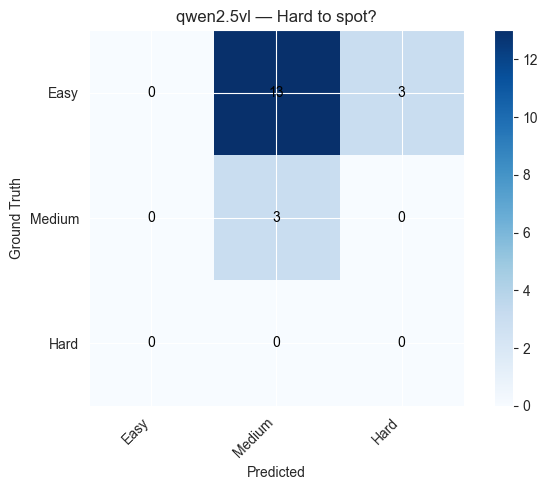

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__qwen2.5vl__Accident_or_design.png


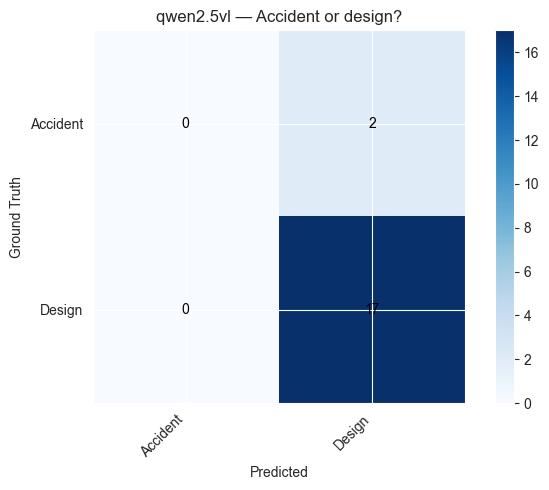

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__qwen2.5vl__Emotion.png


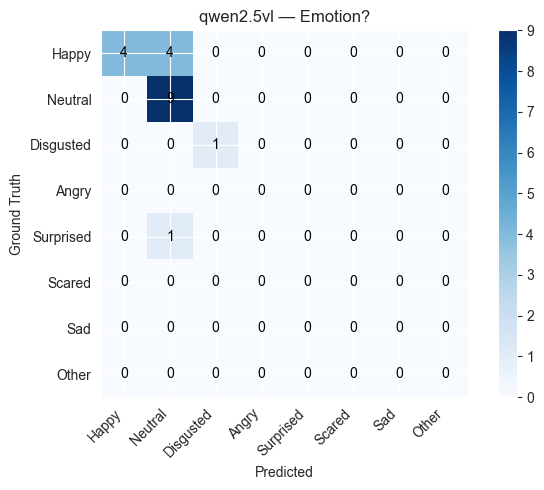

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__qwen2.5vl__Person_or_creature.png


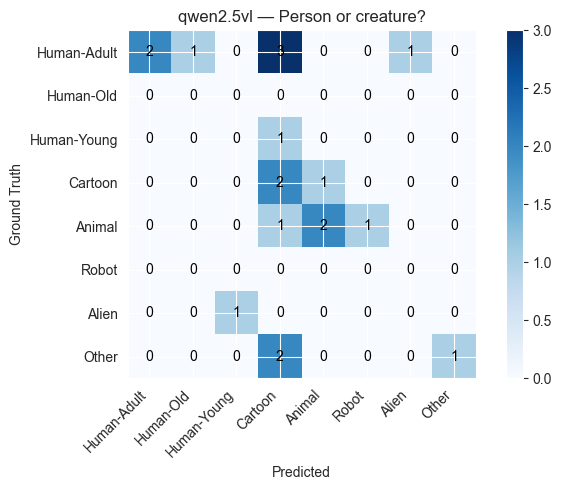

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__qwen2.5vl__Gender.png


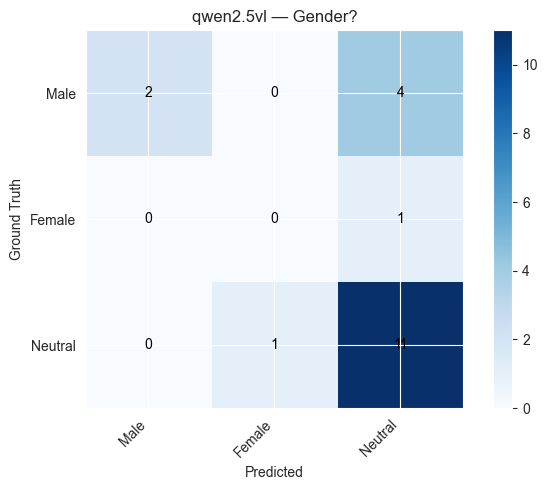

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__qwen2.5vl__Amusing.png


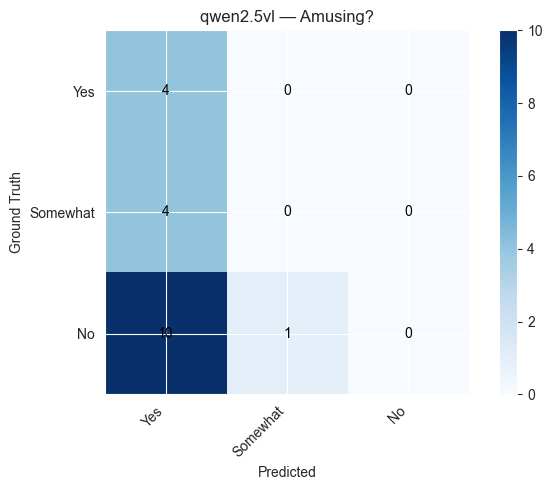

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemma3__Hard_to_spot.png


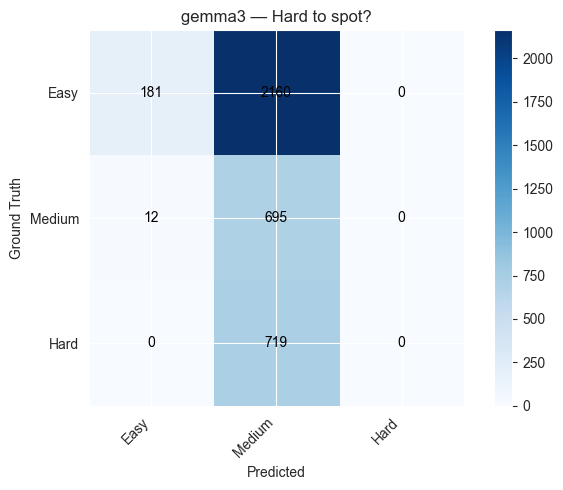

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemma3__Accident_or_design.png


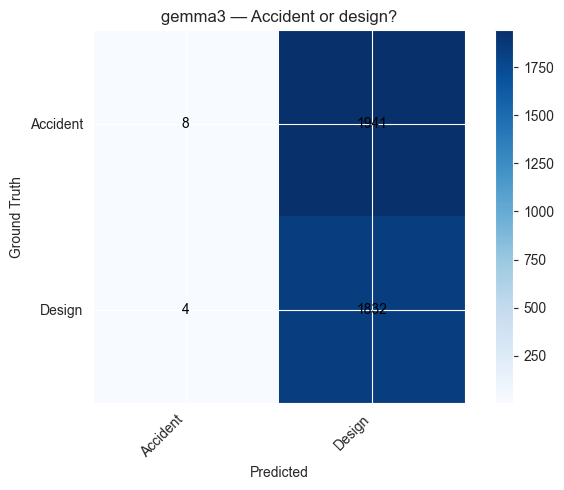

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemma3__Emotion.png


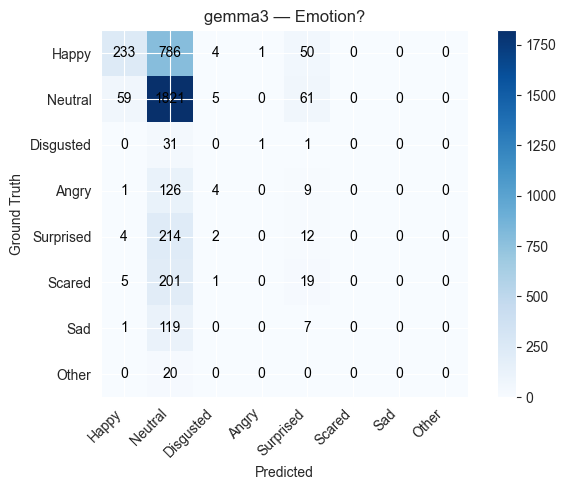

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemma3__Person_or_creature.png


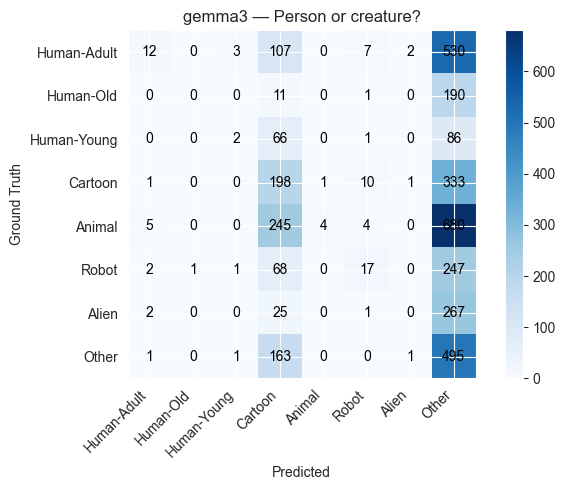

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemma3__Gender.png


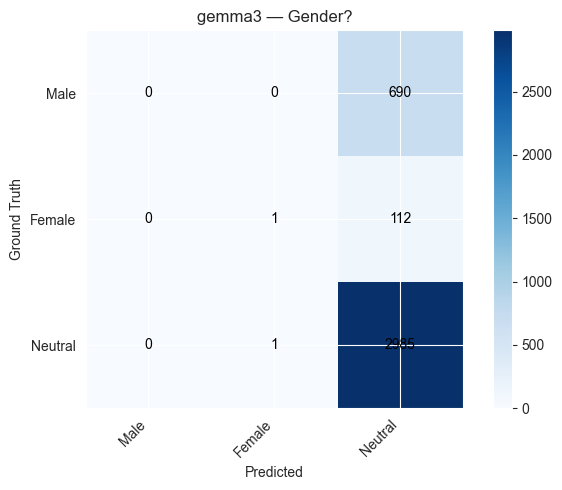

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/plots/cm__gemma3__Amusing.png


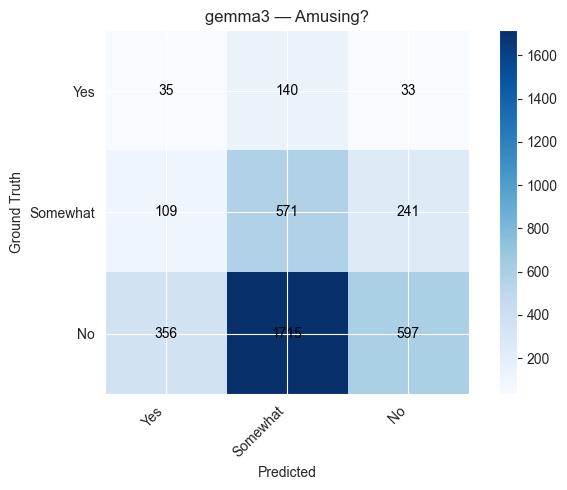

In [56]:
for model_name, merged in merged_by_model.items():
    for attr in ATTRS:
        sub = merged.loc[ merged[f"{attr}_is_valid"] ].copy()
        labels = CANON[attr]
        cm = confusion_from_series(
            sub[f"{attr}_gt_norm"], sub[f"{attr}_pred_norm"], labels
        )
        fname = PLOTS_DIR / f"cm__{model_name}__{attr.replace(' ','_').replace('?','')}.png"
        plot_confusion(cm, labels, f"{model_name} — {attr}", fname=fname, annotate=True)


## Latency

Saved plot: /Users/precioux/Desktop/creativity/Code/compare_out/plots/latency_boxplot.png


/var/folders/_m/qyd_78r54hlc3qlgxy6q01qm0000gn/T/ipykernel_92449/2688402499.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(latency_data, labels=labels, showfliers=False)


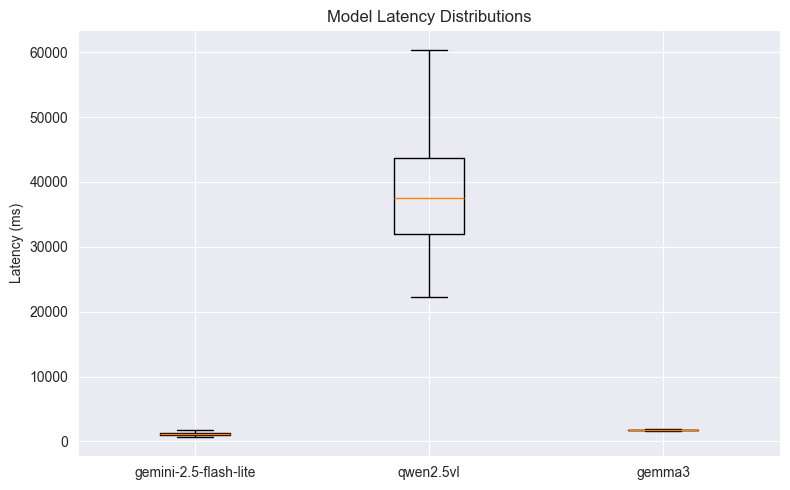

In [40]:
def extract_latencies(df_pred: pd.DataFrame):
    col = None
    if "latency_ms" in df_pred.columns: col = "latency_ms"
    if "latency_ms_predfile" in df_pred.columns: col = "latency_ms_predfile"
    if col is None: return []
    lat = pd.to_numeric(df_pred[col], errors="coerce")
    return lat.dropna().astype(float).tolist()

latency_data, labels = [], []
for model_name, df_pred in models.items():
    L = extract_latencies(df_pred)
    if len(L) > 0:
        latency_data.append(L)
        labels.append(model_name)

if len(latency_data) > 0:
    fig, ax = plt.subplots()
    ax.boxplot(latency_data, labels=labels, showfliers=False)
    ax.set_ylabel("Latency (ms)")
    ax.set_title("Model Latency Distributions")
    fig.tight_layout()
    fig_path = PLOTS_DIR / "latency_boxplot.png"
    fig.savefig(fig_path, dpi=150)
    print("Saved plot:", fig_path)
    plt.show()
else:
    print("No latency data found.")


## Coverage vs Accuracy (baseline view)

Saved plot: /Users/precioux/Desktop/creativity/Code/compare_out/plots/coverage_vs_accuracy.png


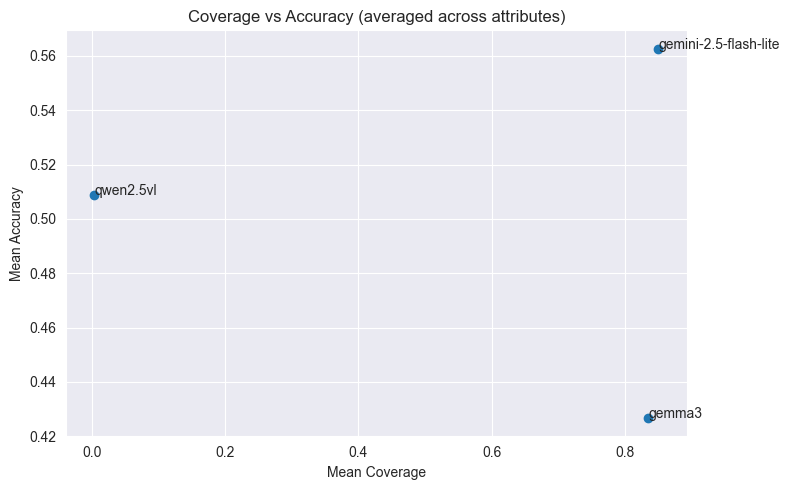

Saved: /Users/precioux/Desktop/creativity/Code/compare_out/coverage_accuracy_summary.csv


In [41]:
if len(summary) > 0:
    agg = summary.groupby("model").agg(
        mean_accuracy=("accuracy","mean"),
        mean_macro_f1=("macro_f1","mean"),
        mean_coverage=("coverage","mean")
    ).reset_index()

    fig, ax = plt.subplots()
    ax.scatter(agg["mean_coverage"], agg["mean_accuracy"])
    for _, r in agg.iterrows():
        ax.annotate(r["model"], (r["mean_coverage"], r["mean_accuracy"]))
    ax.set_xlabel("Mean Coverage")
    ax.set_ylabel("Mean Accuracy")
    ax.set_title("Coverage vs Accuracy (averaged across attributes)")
    fig.tight_layout()
    fig_path = PLOTS_DIR / "coverage_vs_accuracy.png"
    fig.savefig(fig_path, dpi=150)
    print("Saved plot:", fig_path)
    plt.show()

    agg_path = OUT_DIR / "coverage_accuracy_summary.csv"
    agg.to_csv(agg_path, index=False)
    print("Saved:", agg_path)
else:
    print("Summary is empty; skipping.")


## Mismatch Exports

In [43]:
for model_name, merged in merged_by_model.items():
    for attr in ATTRS:
        sub = merged.loc[ merged[f"{attr}_is_valid"] ].copy()
        mism = sub[sub[f"{attr}_gt_norm"] != sub[f"{attr}_pred_norm"]][
            ["image_path", f"{attr}_gt_norm", f"{attr}_pred_norm"]
        ]
        if len(mism) > 0:
            outp = OUT_DIR / f"mismatches__{model_name}__{attr.replace(' ','_').replace('?','')}.csv"
            mism.head(50).to_csv(outp, index=False)
            print("Saved mismatch head:", outp)

# Also export merged heads for convenience
for model_name, merged in merged_by_model.items():
    outp = OUT_DIR / f"merged_head__{model_name}.csv"
    merged.head(200).to_csv(outp, index=False)
    print("Saved merged head:", outp)


Saved mismatch head: /Users/precioux/Desktop/creativity/Code/compare_out/mismatches__gemini-2.5-flash-lite__Hard_to_spot.csv
Saved mismatch head: /Users/precioux/Desktop/creativity/Code/compare_out/mismatches__gemini-2.5-flash-lite__Accident_or_design.csv
Saved mismatch head: /Users/precioux/Desktop/creativity/Code/compare_out/mismatches__gemini-2.5-flash-lite__Emotion.csv
Saved mismatch head: /Users/precioux/Desktop/creativity/Code/compare_out/mismatches__gemini-2.5-flash-lite__Person_or_creature.csv
Saved mismatch head: /Users/precioux/Desktop/creativity/Code/compare_out/mismatches__gemini-2.5-flash-lite__Gender.csv
Saved mismatch head: /Users/precioux/Desktop/creativity/Code/compare_out/mismatches__gemini-2.5-flash-lite__Amusing.csv
Saved mismatch head: /Users/precioux/Desktop/creativity/Code/compare_out/mismatches__qwen2.5vl__Hard_to_spot.csv
Saved mismatch head: /Users/precioux/Desktop/creativity/Code/compare_out/mismatches__qwen2.5vl__Accident_or_design.csv
Saved mismatch head: /

## Compact Summary

In [44]:
def pct(x): 
    return "—" if pd.isna(x) else f"{x*100:.1f}%"

display_cols = ["model","attribute","support","coverage","accuracy","macro_f1","weighted_f1"]
disp = summary[display_cols].copy()
disp["coverage"]    = disp["coverage"].map(pct)
disp["accuracy"]    = disp["accuracy"].map(pct)
disp["macro_f1"]    = disp["macro_f1"].map(pct)
disp["weighted_f1"] = disp["weighted_f1"].map(pct)
disp.sort_values(["attribute","macro_f1","accuracy"], ascending=[True, False, False]).head(40)


,model,attribute,support,coverage,accuracy,macro_f1,weighted_f1
7,qwen2.5vl,Accident or design?,19,0.4%,89.5%,94.4%,84.5%
1,gemini-2.5-flash-lite,Accident or design?,3854,84.9%,82.5%,82.4%,82.4%
13,gemma3,Accident or design?,3785,83.4%,48.6%,33.1%,32.1%
11,qwen2.5vl,Amusing?,19,0.4%,21.1%,36.4%,7.7%
17,gemma3,Amusing?,3797,83.7%,31.7%,25.9%,32.5%
5,gemini-2.5-flash-lite,Amusing?,3866,85.2%,19.9%,20.1%,22.3%
8,qwen2.5vl,Emotion?,19,0.4%,73.7%,81.6%,70.4%
14,gemma3,Emotion?,3798,83.7%,54.4%,36.4%,45.4%
2,gemini-2.5-flash-lite,Emotion?,3867,85.2%,60.8%,28.8%,59.1%
10,qwen2.5vl,Gender?,19,0.4%,68.4%,64.3%,65.4%
